In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

start = time.perf_counter()

In [4]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1049 non-null   object 
 1   SeasonNumber       1049 non-null   int64  
 2   SeasonVersion      1049 non-null   int64  
 3   Player             1049 non-null   object 
 4   MatchId            1049 non-null   object 
 5   Map                1049 non-null   object 
 6   Category           1049 non-null   object 
 7   Playlist           1049 non-null   object 
 8   Input              1049 non-null   object 
 9   Queue              1049 non-null   object 
 10  PreCsr             1049 non-null   int64  
 11  PostCsr            1049 non-null   int64  
 12  Rank               1049 non-null   int64  
 13  WasAtStart         1049 non-null   int64  
 14  WasAtEnd           1049 non-null   int64  
 15  WasInProgressJoin  1049 non-null   int64  
 16  Mmr                2 non

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Ratios
df['Assists/Life'] = df['Assists'] / df['Deaths']
df.loc[df['Assists/Life'] == np.inf, 'Damage/KA'] = df['Assists']
df['Damage/KA'] = df['DamageDone'] / (df['Assists'] + df['Kills'])
df.loc[df['Damage/KA'] == np.inf, 'Damage/KA'] = df['DamageDone']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr', 'SeasonNumber', 'SeasonVersion'],axis=1)
dfr = df[df['Date']> '2023-01-01']
dfr = dfr[dfr['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                          (dfr['Outcome'].cumsum() + 
                           dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('df.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               775 non-null    int64         
 1   Date                775 non-null    datetime64[ns]
 2   Map                 775 non-null    object        
 3   Category            775 non-null    object        
 4   Rank                775 non-null    int64         
 5   Outcome             775 non-null    int64         
 6   Accuracy            775 non-null    float64       
 7   DamageDone          775 non-null    int64         
 8   DamageTaken         775 non-null    int64         
 9   ShotsFired          775 non-null    int64         
 10  ShotsLanded         775 non-null    int64         
 11  ShotsMissed         775 non-null    int64         
 12  KD                  775 non-null    float64       
 13  KDA                 775 non-null    float64       

In [6]:
dfr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
index,775.0,602.383226,265.160731,140.000000,371.500000,601.000000,835.500000,1.048000e+03
Rank,775.0,3.962581,2.151832,1.000000,2.000000,4.000000,5.000000,8.000000e+00
Outcome,775.0,0.553548,0.497445,0.000000,0.000000,1.000000,1.000000,1.000000e+00
Accuracy,775.0,52.622323,6.005983,0.000000,49.290000,52.790000,56.120000,8.056000e+01
DamageDone,775.0,5263.478710,1824.379458,0.000000,3916.000000,5049.000000,6504.000000,1.267300e+04
DamageTaken,775.0,4515.020645,1553.407214,0.000000,3478.000000,4350.000000,5559.500000,9.962000e+03
ShotsFired,775.0,234.592258,79.549792,0.000000,179.500000,227.000000,288.500000,5.170000e+02
ShotsLanded,775.0,123.280000,42.961768,0.000000,94.000000,118.000000,152.000000,2.860000e+02
ShotsMissed,775.0,111.312258,40.264603,0.000000,83.000000,108.000000,137.000000,2.610000e+02
KD,775.0,1.263845,0.740827,0.000000,0.840000,1.120000,1.460000,1.000000e+01


In [7]:
# dfr.tail()
print(round(dfr.sort_values('Dmg/10Min', ascending=False).iloc[:, :30],2).head(8))


     index                Date        Map          Category  Rank  Outcome  \
727    999 2024-04-07 18:05:50   Recharge           Oddball     3        1   
12     154 2023-10-20 19:33:13   Recharge        Extraction     1        1   
263    455 2023-11-27 22:55:34  Forbidden    CTF 3 Captures     3        1   
729   1001 2024-04-07 18:28:23   Empyrean    CTF 3 Captures     4        1   
310    513 2023-12-01 04:37:03   Solitude       Strongholds     5        0   
420    644 2024-01-18 02:37:59    Streets            Slayer     4        1   
305    502 2023-12-01 02:54:53   Solitude  King of the Hill     4        1   
756   1030 2024-04-14 16:11:47   Empyrean    CTF 3 Captures     3        1   

     Accuracy  DamageDone  DamageTaken  ShotsFired  ...  Assists  Betrayals  \
727     61.45        6536         3003         262  ...       11          0   
12      58.10        4996         2339         210  ...        6          0   
263     60.94        3255         1110         128  ...     

In [8]:
# dfr.hist(bins=15, figsize=(18, 14))
# plt.tight_layout()
# plt.show()

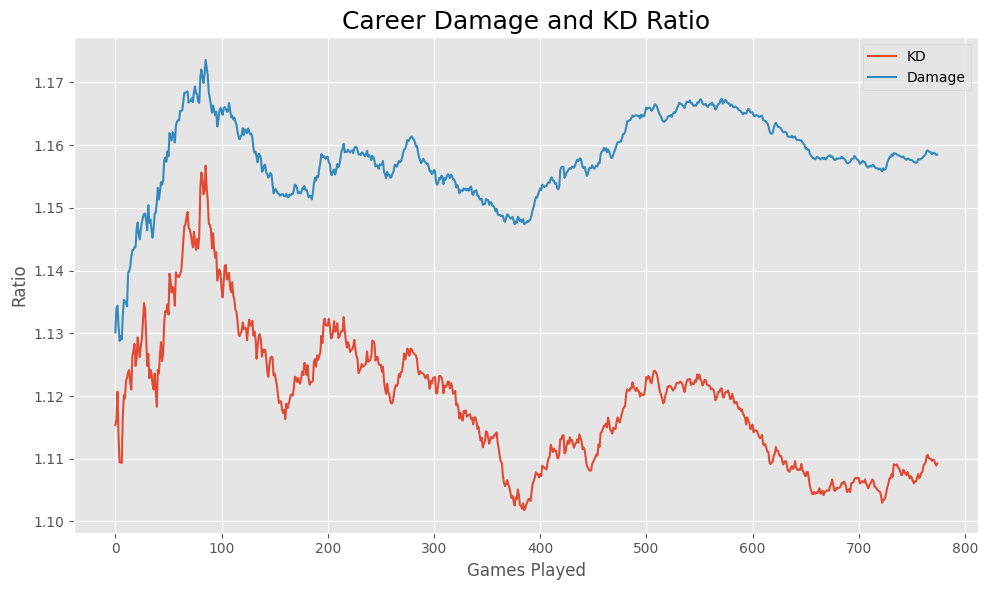

In [9]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeKD'], label='KD' )
plt.plot(dfr['LifetimeDmgRatio'], label='Damage')
plt.title('Career Damage and KD Ratio', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Ratio')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/DamKD.png', dpi=300)
plt.show()

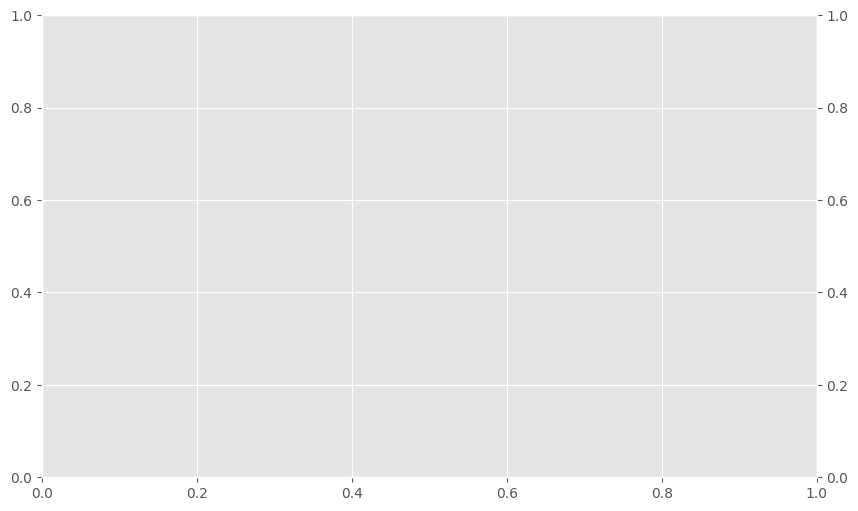

In [10]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams['animation.embed_limit'] = 300.0

dfr_date = dfr.index
dfr_kd = dfr['LifetimeKD']
dfr_dam = dfr['LifetimeDmgRatio']
dfr_csr = dfr['Csr']

# then assign df_date to x and df_close to y
x = dfr_date
y = dfr_kd
y2 = dfr_dam
y3 = dfr_csr

# calculate min and max x values + 1 and
# the min and max y values times scale factors
min_x = min(x)
max_x = max(x)
min_y = min(min(y), min(y2))
max_y = max(max(y), max(y2))
min_y3 = min(y3)
max_y3 = max(y3)

#########################################################################################
# generate and display animation line plot
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax2 = ax.twinx()

def animate(i):
    ax.cla() # clear the previous image
    ax2.cla()
    plt.title('KD/Damage Ratio and CSR over Time',fontsize=16)
    plt.xlabel('Game Played')
    plt.ylabel('Ratios/CSR')
    ax.plot(x[:i], y[:i], label='KD') # plot the line
    ax.plot(x[:i], y2[:i], label='Damage') # plot the line
    ax2.plot(x[:i], y3[:i], label='CSR', color='black')
    ax.set_xlim([0.99*min_x, 0.99*max_x]) # fix the x axis
    ax.set_ylim([0.99*min_y, 1.01*max_y]) # fix the y axis 
    ax2.set_xlim([0.99*min_x, 0.99*max_x])
    ax2.set_ylim(min_y3, 1.05*max_y3)
    ax.legend(loc='upper right')
#     ax2.legend(loc='lower right')
    
# anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 15)

# anim.save('Plots/KDDamCSR.gif', writer='imagemagick', fps=60)

# # Save the animation as HTML
# html_output = anim.to_html5_video()
# # Display the HTML animation in the Jupyter Notebook
# HTML(html_output)

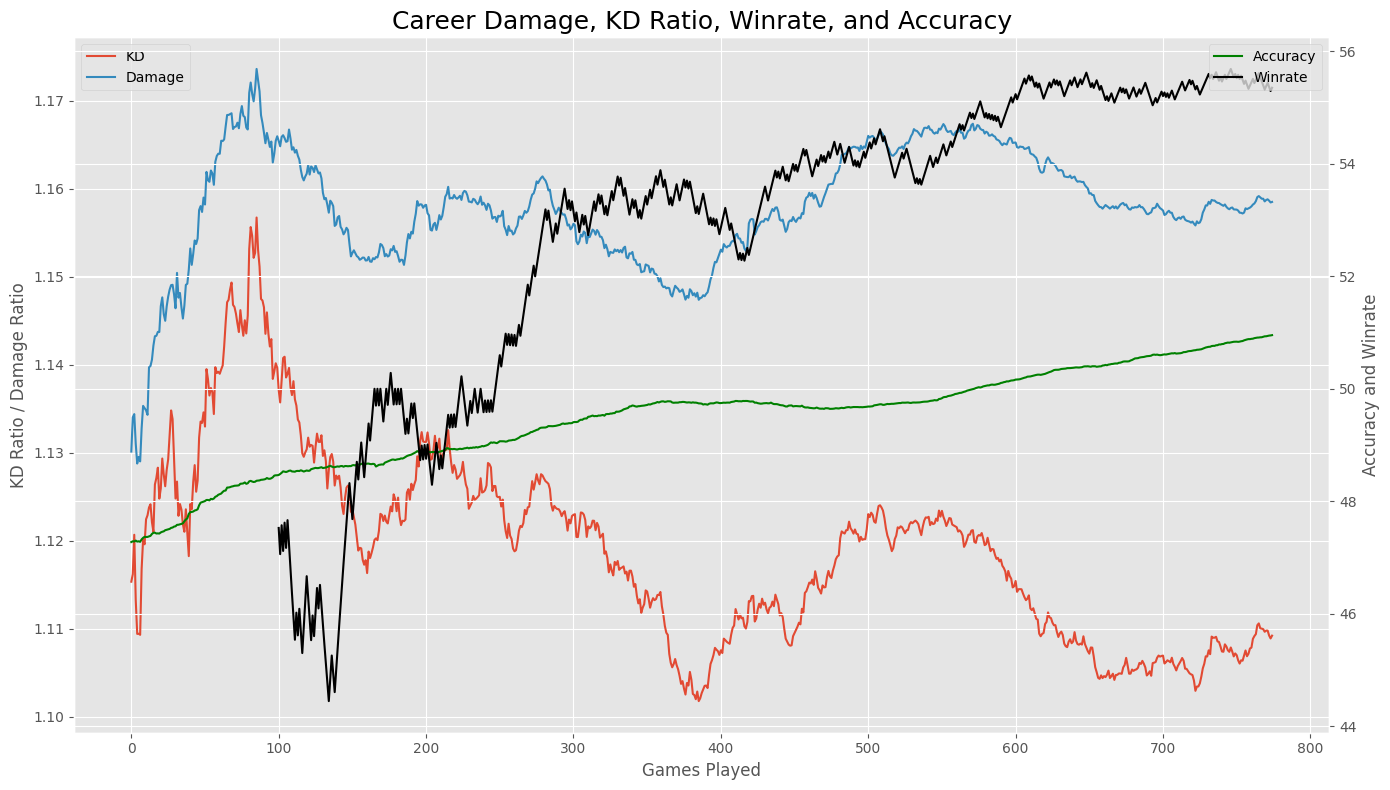

In [11]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['LifetimeAcc'], color='green', label='Accuracy')
ax2.plot(dfr['LifetimeWinRate'][100:]*100, color='black', label='Winrate')
ax1.set_title('Career Damage, KD Ratio, Winrate, and Accuracy', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('Accuracy and Winrate')

ax1.yaxis.grid(True)
ax2.yaxis.grid(True)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDWRAcc.png', dpi=300)
plt.show()

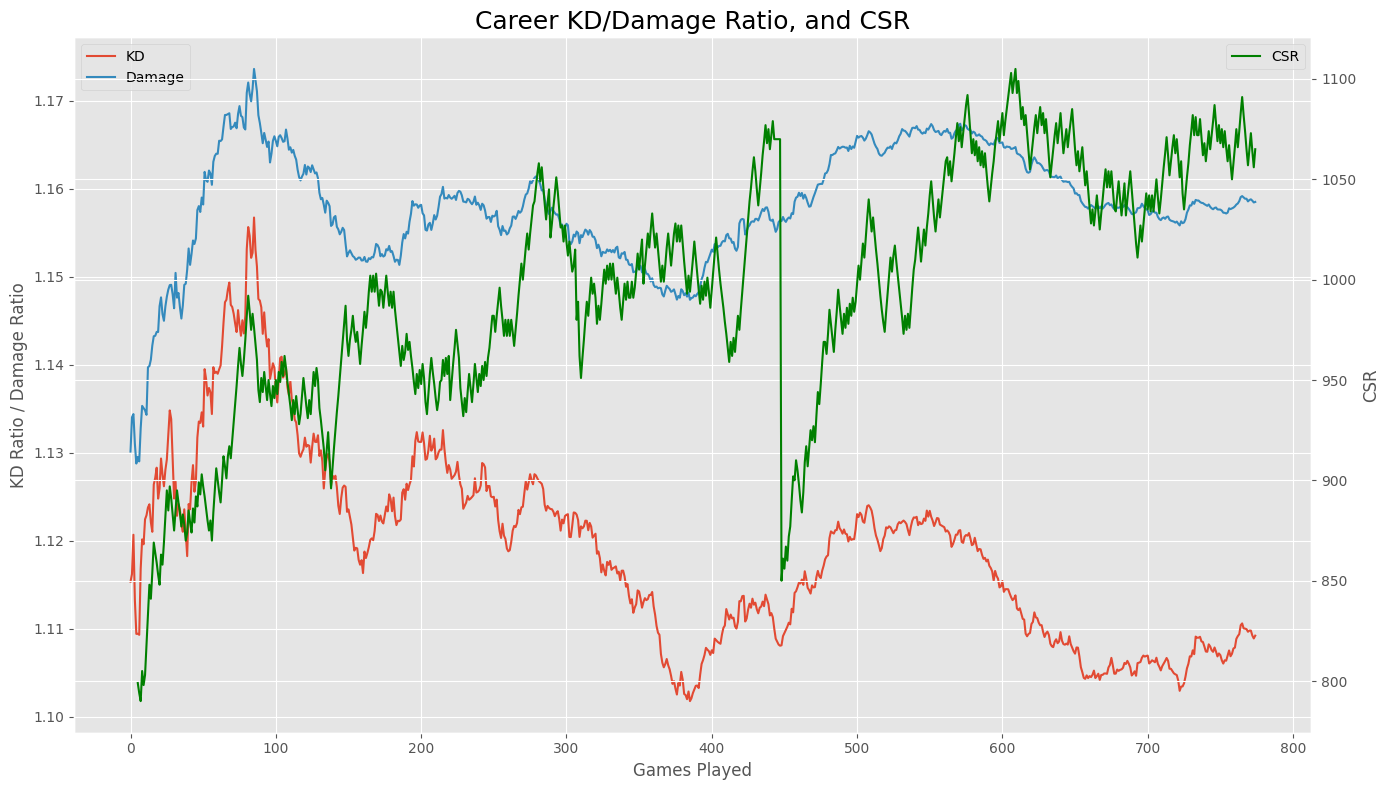

In [12]:
plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][5:], label='CSR', color='green')
ax1.set_title('Career KD/Damage Ratio, and CSR', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
# ax1.yaxis.grid(True)
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig('Plots/DamKDCsr.png', dpi=300)
plt.show()

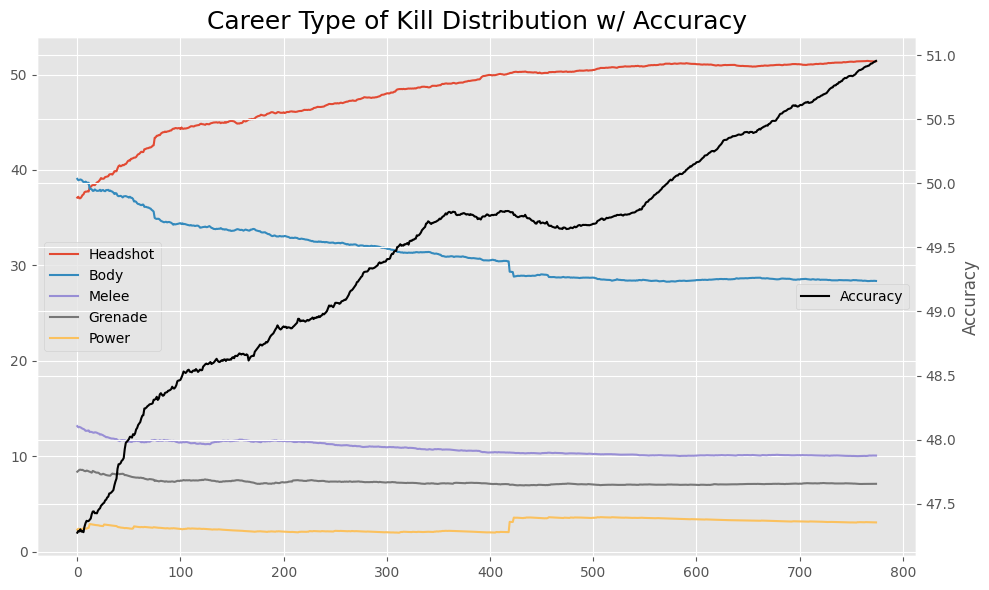

In [13]:
plt.figure(figsize=(10,6))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeHSPct'], label='Headshot')
ax1.plot(dfr['LifetimeBodyPct'], label='Body')
ax1.plot(dfr['LifetimeMeleePct'], label='Melee')
ax1.plot(dfr['LifetimeGrenadePct'], label='Grenade')
ax1.plot(dfr['LifetimePowerPct'], label='Power')
ax2.plot(dfr['LifetimeAcc'], label='Accuracy', color='black')
plt.title('Career Type of Kill Distribution w/ Accuracy', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('Accuracy')
ax1.legend(loc='best')
ax2.legend(loc='right')
ax1.grid(True, axis='y')
plt.tight_layout()
plt.savefig('Plots/TypeKillAcc.png', dpi=300)
plt.show()

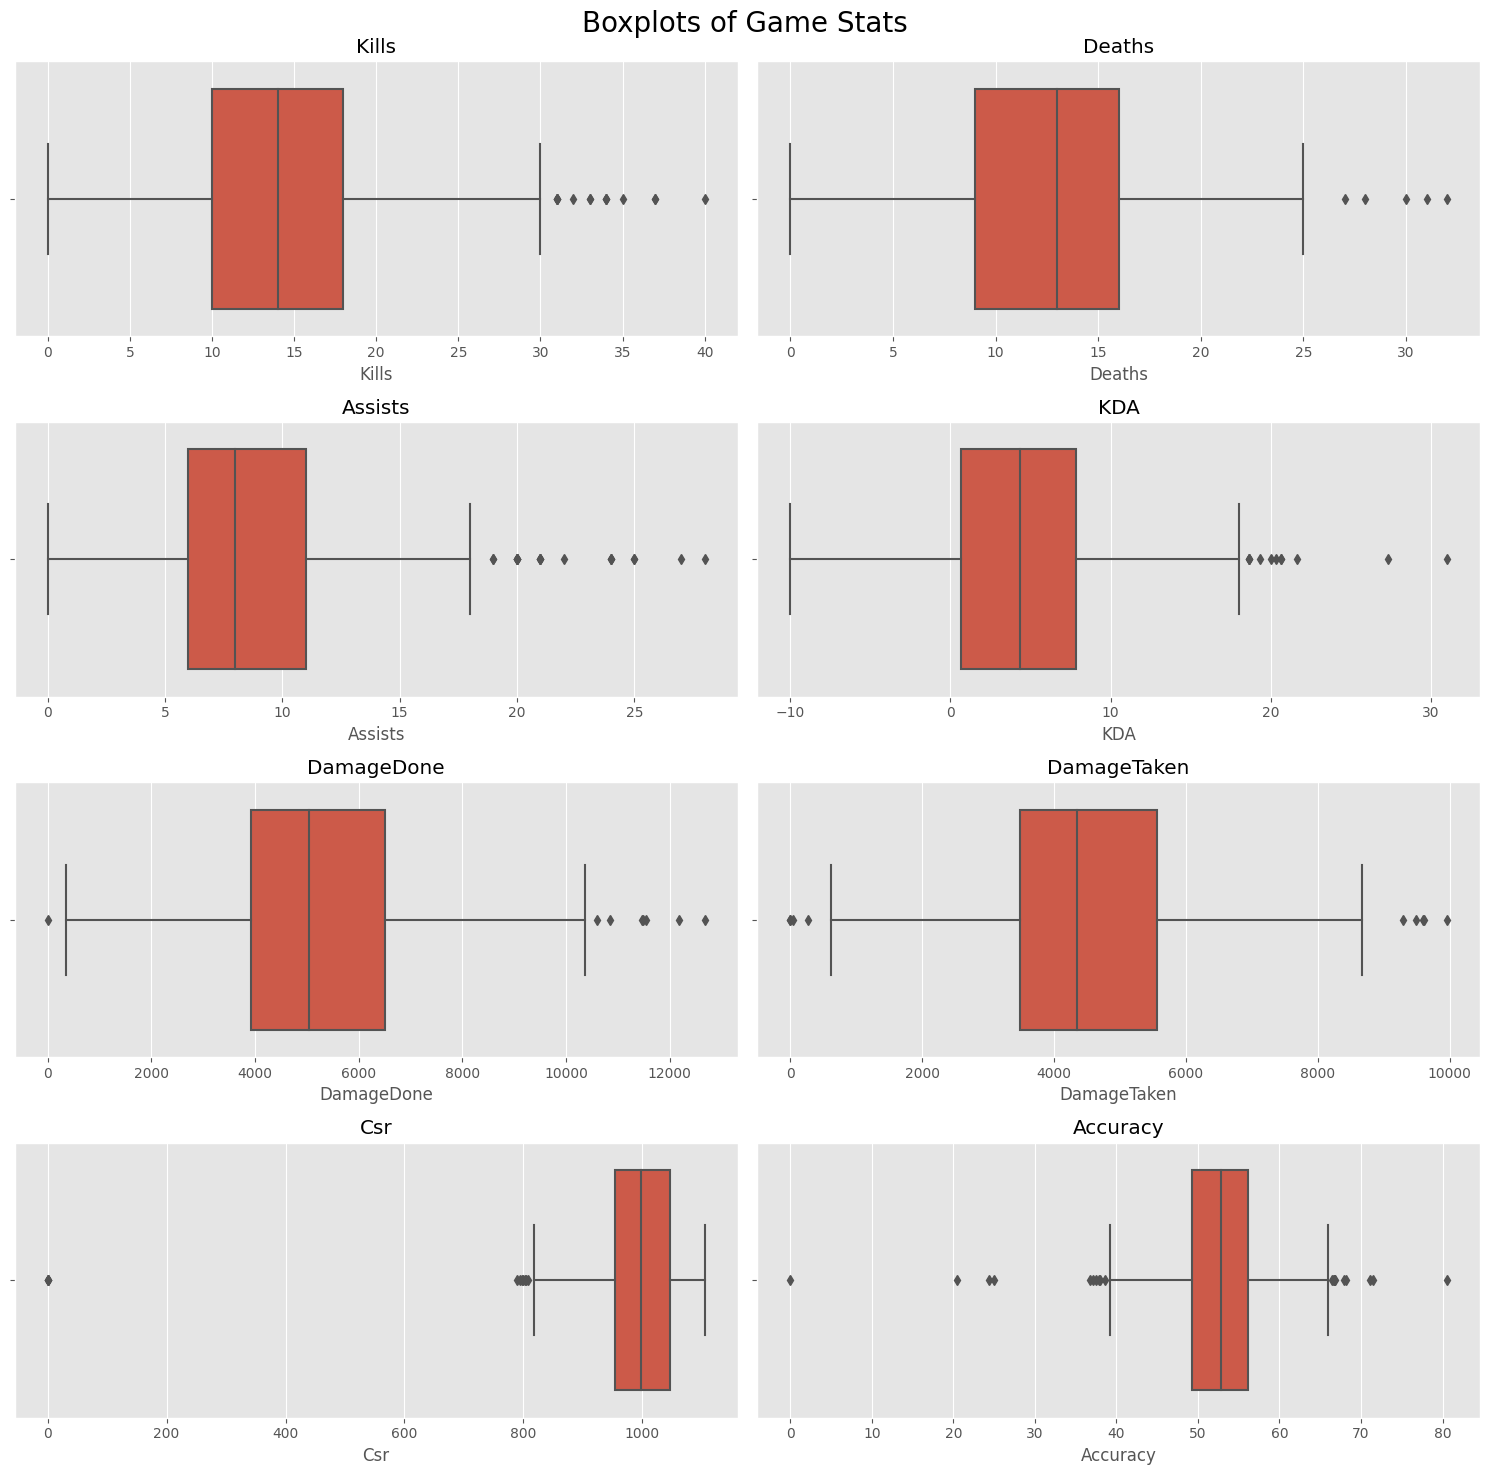

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle('Boxplots of Game Stats', fontsize=20)
plt.tight_layout()
plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


Last * Games stats  
Set mod to however many game you want to view 

In [15]:
# Last * Games

# mod = 10
# dfmod = dfr.tail(mod)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
# dfmod = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

# print(dfmod.head())
print(f'Overall KD: {round(dfmod["Kills"].sum() / dfmod["Deaths"].sum(),2)}')
print(f"Accuracy: {round(dfmod['ShotsLanded'].sum() / dfmod['ShotsFired'].sum()*100,2)}")
print(f"Damage Ratio: {round(dfmod['DamageDone'].sum() / dfmod['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfmod['Outcome']==1).sum()}-{(dfmod['Outcome']==0).sum()}")
print(f"Winrate: {round((dfmod['Outcome']==1).sum() / (dfmod['Outcome']==0).sum() ,2)}")
print(f"Max CSR: {dfmod['Csr'].max()}")
# dfmod.sort_values('Kills', ascending=False).head(10)



Overall KD: 1.25
Accuracy: 53.17
Damage Ratio: 1.25
Win-Loss: 370-233
Winrate: 1.59
Max CSR: 1105


In [16]:
df['Assists/Life'].head(20)

0     0.333333
1     0.636364
2     0.111111
3     1.500000
4     0.666667
5     0.250000
6     0.500000
7     0.333333
8     1.000000
9     0.812500
10    0.200000
11    0.857143
12    0.454545
13    0.666667
14    0.636364
15    0.500000
16    1.333333
17    0.833333
18    0.333333
19    0.650000
Name: Assists/Life, dtype: float64

In [34]:
import plotly.express as px

mod = 10

fig = px.line(dfr, x=dfr.index, y= (dfr['ShotsLanded'].rolling(window=mod).sum() /
                                   dfr['ShotsFired'].rolling(window=mod).sum()*100), 
              labels={'x':"# of Games Played", 'y': 'Accuracy'},
              title='Rolling Avg Accuracy')

fig.show()


In [18]:
import plotly.express as px

mod = 50
name = 'Assists/Life'

fig = px.line(dfr, x=dfr.index, y=(dfr['Assists'].rolling(window=mod).mean() /
                                 dfr['Deaths'].rolling(window=mod).mean()), 
              labels={'x': 'Number of Games Played', 'y': f'{name}'},
              title=f'Rolling Avg {name}')

fig.show()


In [19]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfmod = dfr[dfr['DamageTaken'] < dfr['DamageDone']]
dfmod1 = dfr[dfr['DamageTaken'] > dfr['DamageDone']]

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Dmg Done <> Taken: {len(dfmod)}-{len(dfmod1)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Totals')
print(f"Total Games: {dfr.Kills.count()}")
print(f"Total Kills: {dfr.Kills.sum()}")
print(f"Total Deaths: {dfr.Deaths.sum()}")
print(f"Total Assists: {dfr.Assists.sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.14
Average Kills: 13.62
Average Deaths: 11.97
Average Assists: 8.11
Average Accuracy: 52.55
Average Damage Done: 5263
Average Damage Taken: 4515
Damage Ratio: 1.17
Dmg Done <> Taken: 603-171
Win-Loss: 429-346
----------------------------
Totals
Total Games: 775
Total Kills: 11235
Total Deaths: 9983
Total Assists: 6665
----------------------------
Wins
Overall KD: 1.32
Average Kills: 14.15
Average Deaths: 10.72
Average Assists: 8.58
Average Accuracy: 52.85
Average Damage Done: 5090
Average Damage Taken: 4147
Damage Ratio: 1.23
Wins: 429
----------------------------
Losses
Overall KD: 0.96
Average Kills: 12.97
Average Deaths: 13.52
Average Assists: 7.53
Average Accuracy: 52.2
Average Damage Done: 5479
Average Damage Taken: 4971
Damage Ratio: 1.1
Losses: 346


In [20]:
# Ranks, 1 = Top Winner, 5 = Top Loser
g1 = dfr[dfr['Rank'] == 1].value_counts().count()
g5 = dfr[dfr['Rank'] == 5].value_counts().count()
g15 = round((g1 + g5) / len(dfr)*100,2)


print('Games Ranked 1:',g1)
print('Games Ranked 5:',g5)
print('MVP %:',g15 )

Games Ranked 1: 157
Games Ranked 5: 169
MVP %: 42.06


## Scorigami
Inspired by NFL, tracks unique statlines and counts if theyve occured before, only shows duplicate records instead of unique

In [21]:
# Create a new column for the combined score in the desired format
dfGami = pd.DataFrame()
dfGami['Kills'] = dfr['Kills']
dfGami['Deaths'] = dfr['Deaths']
dfGami['Assists'] = dfr['Assists']
dfGami['Scorigami'] = dfr['Kills'].astype(str) + '-' + dfr['Deaths'].astype(str) + '-' + dfr['Assists'].astype(str)

# Get unique scorigami scores
scorigami_list = dfGami['Scorigami'].unique()

dfGami = dfGami.sort_values(by=['Kills', 'Deaths', 'Assists'], ascending=False)
# print(dfGami.head())
dfGami.to_csv('Scorigami.csv')

In [22]:
gamiPiv = dfGami.pivot_table(index='Scorigami', aggfunc='size')

gamiPiv = gamiPiv.sort_index()

print("Records with >= 3 Scori:",gamiPiv[gamiPiv.values>2].count())
print(gamiPiv[gamiPiv.values>2].sort_values(ascending=False))


Records with >= 3 Scori: 8
Scorigami
13-11-9     3
15-8-7      3
17-15-9     3
17-16-10    3
19-18-10    3
6-11-8      3
7-12-7      3
8-11-5      3
dtype: int64


In [23]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
round(dfrc.sort_values('Length%', ascending=False),2)

,LengthMinutes,Count,Length%,Count%
Category,,,,
Slayer,1511.90,176,18.56,22.71
CTF 3 Captures,1482.53,135,18.20,17.42
Oddball,1395.95,116,17.13,14.97
Strongholds,1335.55,114,16.39,14.71
King of the Hill,1319.23,123,16.19,15.87
Extraction,611.85,70,7.51,9.03
CTF 5 Captures,490.28,41,6.02,5.29


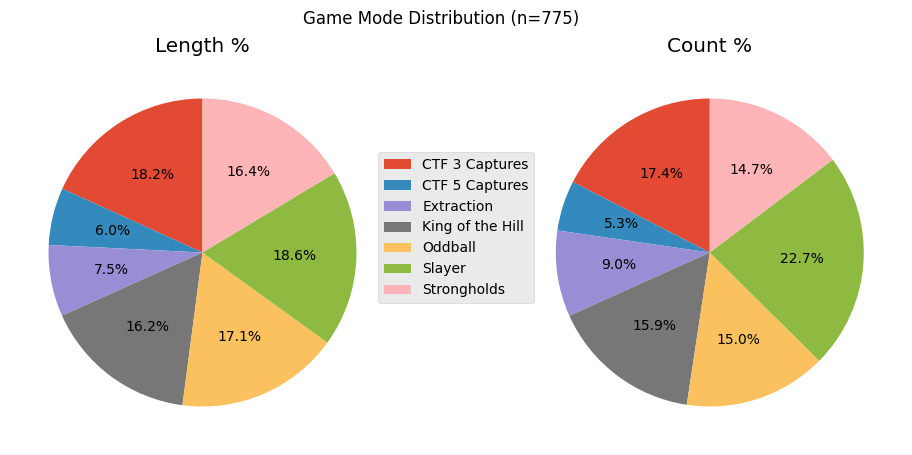

In [24]:
import matplotlib.pyplot as plt

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
fig.suptitle(f'Game Mode Distribution (n={totalcount})')
ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")
plt.savefig('Plots/ModeDistro.png', dpi=300)
plt.show()

In [25]:
dfrc = dfr.groupby(['Category','Map']).agg({'Category': 'count', 'LengthMinutes': 'sum', 'Outcome': 'mean'})
dfrc.rename(columns={'Category': 'Count', 'LengthMinutes': 'LengthHours'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthHours']/60,2)
dfrc['Outcome'] = round(dfrc['Outcome'],2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['Length%'] = round(dfrc['LengthHours'] / dfrc['LengthHours'].sum() * 100,2)
dfrc = dfrc.sort_values(['Length%'], ascending=False)
dfrc

,,Count,LengthHours,Outcome,Count%,Length%
Category,Map,,,,,
King of the Hill,Recharge,52,9.71,0.50,6.71,7.15
CTF 3 Captures,Argyle,50,9.50,0.48,6.45,7.00
Oddball,Streets,46,9.35,0.59,5.94,6.89
Strongholds,Solitude,45,9.20,0.47,5.81,6.78
CTF 3 Captures,Empyrean,43,8.27,0.51,5.55,6.09
CTF 5 Captures,Aquarius,41,8.17,0.44,5.29,6.02
Oddball,Recharge,39,7.69,0.62,5.03,5.66
Slayer,Solitude,51,7.50,0.67,6.58,5.52
CTF 3 Captures,Forbidden,42,6.93,0.57,5.42,5.10


In [26]:
dfrcc = dfr.groupby(['Category','Map']).agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)

dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) * 100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['Dmg/KA'] = dfrcc['DamageDone'] / (dfrcc['Kills'] + dfrcc['Assists'])
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min']
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
dfrcc = round(dfrcc.sort_values(['Winrate', 'Category', 'Map'], ascending=False), 2)
dfrcc

Count  Wins  Losses  Kills  Deaths  Assists  \
Category         Map                                                      
King of the Hill Live Fire     38    27      11    565     526      336   
Slayer           Streets       31    21      10    289     281      206   
                 Solitude      51    34      17    540     535      363   
                 Recharge      17    11       6    162     159      115   
Oddball          Recharge      39    24      15    635     528      406   
Extraction       Recharge      18    11       7    230     193      143   
                 Streets       33    20      13    453     351      253   
Oddball          Streets       46    27      19    802     725      493   
                 Live Fire     31    18      13    512     497      321   
CTF 3 Captures   Forbidden     42    24      18    548     436      276   
Slayer           Aquarius      49    27      22    519     502      326   
King of the Hill Solitude      33    18      15    536     440      333   
Strongholds      Live Fire     33    17      16    525     453      247   
CTF 3 Captures   Empyrean      43    22      21    671     613      348   
Slayer           Live Fire     28    14      14    288     287      160   
King of the Hill Recharge      52    26      26    868     772      615   
CTF 3 Captures   Argyle        50    24      26    748     633      362   
Strongholds      Recharge      36    17      19    509     519      319   
                 Solitude      45    21      24    847     707      507   
CTF 5 Captures   Aquarius      41    18      23    758     610      411   
Extraction       Live Fire     19     8      11    230     216      125   

                            DamageDone  DamageTaken  Winrate  LengthMinutes  \
Category         Map                                                          
King of the Hill Live Fire      201258       181407     0.71         383.33   
Slayer           Streets        118466       104292     0.68         251.20   
                 Solitude       211792       192107     0.67         449.70   
                 Recharge        67949        63215     0.65         153.43   
Oddball          Recharge       230469       191049     0.62         461.32   
Extraction       Recharge        80159        66596     0.61         165.43   
                 Streets        147191       118482     0.61         284.25   
Oddball          Streets        288491       244128     0.59         560.77   
                 Live Fire      188551       161698     0.58         373.87   
CTF 3 Captures   Forbidden      204434       162740     0.57         415.92   
Slayer           Aquarius       203708       182609     0.55         411.95   
King of the Hill Solitude       184539       152890     0.55         353.03   
Strongholds      Live Fire      185000       163190     0.52         374.55   
CTF 3 Captures   Empyrean       241060       214729     0.51         496.48   
Slayer           Live Fire      107861       103330     0.50         245.62   
King of the Hill Recharge       318210       268129     0.50         582.87   
CTF 3 Captures   Argyle         267314       223873     0.48         570.13   
Strongholds      Recharge       197340       177537     0.47         409.28   
                 Solitude       286814       241637     0.47         551.72   
CTF 5 Captures   Aquarius       266227       213152     0.44         490.28   
Extraction       Live Fire       82363        72351     0.42         162.17   

                            Accuracy    KD  DamageRatio  Dmg/Life  Dmg/KA  \
Category         Map                                                        
King of the Hill Live Fire     55.41  1.07         1.11    382.62  223.37   
Slayer           Streets       50.97  1.03         1.14    421.59  239.33   
                 Solitude      50.72  1.01         1.10    395.87  234.54   
                 Recharge      46.72  1.02         1.07    427.35  245.30   
Oddball          Recha

In [27]:
dfrcc = dfr.groupby('Category').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,,,,,,
Slayer,176,107,69,1798,1764,1170,17233,34065,709776,645553,0.61,1511.90,1.02,1.10,402.37,36.41,0.66
Oddball,116,69,47,1949,1750,1220,16027,30147,707511,596875,0.59,1395.95,1.11,1.19,404.29,63.22,0.70
King of the Hill,123,71,52,1969,1738,1284,16228,30603,704007,602426,0.58,1319.23,1.13,1.17,405.07,58.45,0.74
Extraction,70,39,31,913,760,521,7421,13807,309713,257429,0.56,611.85,1.20,1.20,407.52,68.79,0.69
CTF 3 Captures,135,70,65,1967,1682,986,16775,31855,712808,601342,0.52,1482.53,1.17,1.19,423.79,66.27,0.59
Strongholds,114,55,59,1881,1679,1073,15428,29315,669154,582364,0.48,1335.55,1.12,1.15,398.54,51.69,0.64
CTF 5 Captures,41,18,23,758,610,411,6430,12017,266227,213152,0.44,490.28,1.24,1.25,436.44,87.01,0.67


In [28]:
dfrcc = dfr.groupby('Map').agg(
    Count=('Category', 'count'),
    Wins=('Outcome', lambda x: x.eq(1).sum()),  
    Losses=('Outcome', lambda x: x.eq(0).sum()),  
    Kills=('Kills', 'sum'),
    Deaths=('Deaths', 'sum'),
    Assists=('Assists', 'sum'),
    ShotsLanded=('ShotsLanded', 'sum'),
    ShotsFired=('ShotsFired', 'sum'),
    DamageDone=('DamageDone', 'sum'),
    DamageTaken=('DamageTaken', 'sum'),
    Outcome=('Outcome', 'mean'),
    LengthMinutes=('LengthMinutes', 'sum'),
)
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Wins,Losses,Kills,Deaths,Assists,ShotsLanded,ShotsFired,DamageDone,DamageTaken,Winrate,LengthMinutes,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,,,,,,
Streets,110,68,42,1544,1357,952,13183,24587,554148,466902,0.62,1096.22,1.14,1.19,408.36,64.29,0.70
Forbidden,42,24,18,548,436,276,4807,9033,204434,162740,0.57,415.92,1.26,1.26,468.89,95.63,0.63
Solitude,129,73,56,1923,1682,1203,15939,30451,683145,586634,0.57,1354.45,1.14,1.16,406.15,57.38,0.72
Live Fire,149,84,65,2120,1979,1189,17326,32041,765033,681976,0.56,1539.53,1.07,1.12,386.58,41.97,0.60
Recharge,162,89,73,2404,2171,1598,20852,41092,894127,766526,0.55,1772.33,1.11,1.17,411.85,58.78,0.74
Empyrean,43,22,21,671,613,348,5769,10971,241060,214729,0.51,496.48,1.09,1.12,393.25,42.95,0.57
Aquarius,90,45,45,1277,1112,737,11467,21783,469935,395761,0.50,902.23,1.15,1.19,422.60,66.70,0.66
Argyle,50,24,26,748,633,362,6199,11851,267314,223873,0.48,570.13,1.18,1.19,422.30,68.63,0.57


In [29]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 6.620170249952935s
